In [1]:
from io import BytesIO
import requests
import logging
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import rasterio
from scipy import ndimage as ndi
from skimage.transform import resize
from skimage.segmentation import watershed
from skimage.morphology import closing

logging.basicConfig(level=logging.INFO)

In [2]:
# common image attributes

# image resolution "on the ground"
meters_by_pixel = 1  
img_side = 256 # in meters
img_size = (abs(int(img_side/meters_by_pixel)), abs(int(img_side/meters_by_pixel))) # for comparing sources

# image coordinates
x_min = 597500
y_min = 657450
x_max = x_min + img_side
y_max = y_min + img_side

logging.info(f"image coordinates: {(x_min, y_min), (x_max, y_max)}, image size: {img_size} resolution: {img_side}/{meters_by_pixel}")

INFO:root:image coordinates: ((597500, 657450), (597756, 657706)), image size: (256, 256) resolution: 256/1


In [3]:
# GEOPORTAL ORTO
def get_orto_image(aoi, resolution):
    x_min, y_min, x_max, y_max = aoi
    
    ORTO_WMS_URL = "mapy.geoportal.gov.pl/wss/service/PZGIK/ORTO/WMS/StandardResolution"

    layer = 'Raster'
    resolution = resolution
    size = (abs(int((x_min - x_max)/resolution)), abs(int((y_min - y_max)/resolution)))

    params = {
        'request': 'GetMap',
        'service': 'WMS',
        'version': '1.1.1',
        'layers': layer,
        'styles': '',
        'width': size[0],
        'height': size[1],
        'srs': 'EPSG:2180',
        'bbox': ','.join((str(x) for x in (x_min, y_min, x_max, y_max))),
        'format': 'image/png',
        'transparent': 'TRUE'
    }

    parsed_url = "http://" + ORTO_WMS_URL + "?" + "&".join([f"{k.upper()}={v}" for k,v in params.items()])
    
    logging.info(f"Requesting image from get_orto_image({aoi}, {resolution}), img_size: {size}")
    response = requests.get(parsed_url)
    
    if response.ok:

        img = BytesIO(response.content)

        with rasterio.MemoryFile(img) as memfile:
             with memfile.open() as dataset:
                    data_array = dataset.read()
                    data_array = np.moveaxis(data_array, 0, 2)

        return data_array[:,:,:3]
    
    logging.warning(f"Could not get image from get_orto_image({aoi}, {resolution})")
    return 

INFO:root:Requesting image from get_orto_image((597500, 657450, 597756, 657706), 1), img_size: (256, 256)


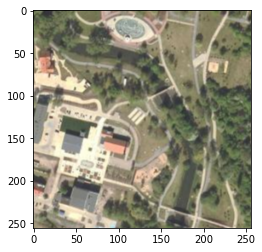

In [6]:
img_orto = get_orto_image((x_min, y_min, x_max, y_max), meters_by_pixel)
plt.imshow(img_orto);

In [7]:
# GEOPORTAL BUILDINGS
def get_building_image(aoi, resolution):
    x_min, y_min, x_max, y_max = aoi
    BUILD_WMS_URL = "integracja.gugik.gov.pl/cgi-bin/KrajowaIntegracjaEwidencjiGruntow"

    layer = 'budynki'
    resolution = resolution
    size = (abs(int((x_min - x_max)/resolution)), abs(int((y_min - y_max)/resolution)))

    params = {
        'request': 'GetMap',
        'service': 'WMS',
        'version': '1.1.1',
        'layers': layer,
        'styles': '',
        'width': size[0],
        'height': size[1],
        'srs': 'EPSG:2180',
        'bbox': ','.join((str(x) for x in (x_min, y_min, x_max, y_max))),
        'format': 'image/png',
        'transparent': 'TRUE'
    }

    parsed_url = "http://" + BUILD_WMS_URL + "?" + "&".join([f"{k.upper()}={v}" for k,v in params.items()])

    logging.info(f"Requesting image from get_orto_image({aoi}, {resolution}), img_size: {size}")
    response = requests.get(parsed_url)
    
    if response.ok:

        img = BytesIO(response.content)

        with rasterio.MemoryFile(img) as memfile:
             with memfile.open() as dataset:
                    data_array = dataset.read()
                    data_array = np.moveaxis(data_array, 0, 2)

        return data_array[:,:,:3]
    
    logging.warning(f"Could not get image from get_orto_image({aoi}, {resolution})")
    return 

INFO:root:Requesting image from get_orto_image((597500, 657450, 597756, 657706), 1), img_size: (256, 256)


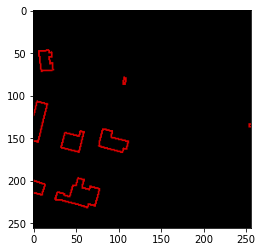

In [8]:
img_build = get_building_image((x_min, y_min, x_max, y_max), meters_by_pixel)
plt.imshow(img_build);

In [9]:
def get_building_mask(aoi, resolution):
    
    logging.info(f"Generating image for get_building_mask({aoi}, {resolution})")
    data_array = get_building_image((x_min, y_min, x_max, y_max), meters_by_pixel)
    
    if data_array is not None:
        data_array = data_array[:,:,0] > 0
        
        # closing contours
        data_array = closing(data_array)
        
        # filling contours
        data_array = ndi.binary_fill_holes(data_array)
        
        # filling open contours with watershed
        water_mask = watershed(data_array)
        water_mask = water_mask != np.bincount(water_mask.flatten()).argmax()
        data_array = water_mask + data_array

        return data_array
    
    logging.warning(f"Could not get image for get_building_mask({aoi}, {resolution})")
    return

INFO:root:Generating image for get_building_mask((597500, 657450, 597756, 657706), 1)
INFO:root:Requesting image from get_orto_image((597500, 657450, 597756, 657706), 1), img_size: (256, 256)


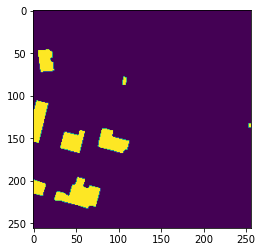

In [10]:
build_mask = get_building_mask((x_min, y_min, x_max, y_max), meters_by_pixel)
plt.imshow(build_mask);